# XOR ANN Optimization using a Genetic Algorith vs Stochastic Gradient Descent

In [1]:
import torch
import torch.nn as nn
from pt_fc_layers_viz import draw_pt_fc_layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import datetime

## Utility Functions

In [2]:
def plot_losses(losses):
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [3]:
def determine_device():
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps" # Apple M1

    print(f"We are using device: {device}")
    return device

## Global Variables

In [4]:
# RANDOM_SEED = np.random.randint(0, 1000)
RANDOM_SEED = 13

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## ANN

In [5]:
class ANN(nn.Module):
    def __init__(self, *, layers=[2, 2, 1], activation_fn=nn.LeakyReLU, requires_grad=False):
        super().__init__()

        # Add each layer followed by the activation function
        module_list = []
        for i in range(len(layers) - 1):
            module_list.append(nn.Linear(layers[i], layers[i + 1]))
            if activation_fn is not None:
                module_list.append(activation_fn())
        if activation_fn is not None:
            module_list.pop() # The last layer should not have an activation function

        self.layers = nn.ModuleList(module_list)

        if requires_grad is False:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

## Data

In [6]:
X = torch.Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = torch.Tensor([[0], [1], [1], [0]])

X.shape, Y.shape

(torch.Size([4, 2]), torch.Size([4, 1]))

## Genetic Algorithm Optimization

### Torch Interaction

In [7]:
def get_all_parameters_as_vector(model: nn.Module) -> torch.Tensor:
    return torch.cat([p.flatten() for p in model.parameters()])

In [8]:
def set_all_parameters_from_vector(model: nn.Module, param_vector: torch.Tensor) -> nn.Module:
    position = 0
    for param in model.parameters():
        num_elements = param.numel()
        values_slice = param_vector[position:position+num_elements]
        param.data.copy_(values_slice.view(param.shape)) # A.copy_(B) copies B values into A
        position += num_elements
    return model

In [9]:
model_0 = ANN(layers=[2, 2, 1])
model_1 = ANN(layers=[2, 2, 1])
set_all_parameters_from_vector(model_1, get_all_parameters_as_vector(model_0))
assert get_all_parameters_as_vector(model_0).equal(get_all_parameters_as_vector(model_1))

### Popultation Initialization

In [11]:
# Could be optimized by using torch internals to initialize parameters instead of creating lots of models.

def get_population_he(model: nn.Module, size: int) -> torch.Tensor:
    layers = []
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            layers.append(layer.in_features)
    layers = layers + [model.layers[-1].out_features]

    activation_fn = type(model.layers[1])
    
    param_pop = []
    for _ in range(size):
        model = ANN(layers=layers, activation_fn=activation_fn)
        
        params = get_all_parameters_as_vector(model)
        param_pop.append(params)

    return torch.stack(param_pop)

In [14]:
# Get random parameters in the range init_range

# def get_population(model: nn.Module, size: int) -> torch.Tensor:
#     original_params = get_all_parameters_as_vector(model)
#     n_params = original_params.numel()
    
#     param_sets = []
#     for _ in range(size):
#         new_params = (torch.rand(n_params) * 2) - 1
#         param_sets.append(new_params)

#     return torch.stack(param_sets)

# In-place version
def get_population(model: nn.Module, size: int, init_range=.5) -> torch.Tensor:
    original_params = get_all_parameters_as_vector(model)
    n_params = original_params.numel()
    
    param_pop = torch.empty(size, n_params)
    
    for i in range(size):
        param_pop[i].uniform_(-init_range, init_range)

    return param_pop

### Fitness Function

In [16]:
def get_fitness(population: torch.Tensor, model: nn.Module, loss_fn: nn.Module, X: torch.Tensor, Y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    losses = []
    for individual in population:
        model = set_all_parameters_from_vector(model, individual)
        y_hat = model(X)
        loss = loss_fn(y_hat, Y).mean().item()
        losses.append(loss)

    losses = torch.Tensor(losses)
    _, ranks = torch.sort(torch.argsort(losses, descending=True)) # argsort sorts the losses descending, then sort sorts the indices of the argsort
    
    return losses, ranks # A high rank means a low loss. population[ranks[0]] is the best individual.

### Selection

In [19]:
def exp_rank_selection(population: torch.Tensor, percentage: float, ranks: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    n_selected = int(percentage * population.shape[0])
    
    # P(i) = (1 - e ^ -i) / c
    # i is the fitness rank and c is a normalization constant according to the population size
    probabilities_without_norm = 1 - torch.exp(-ranks)
    c = probabilities_without_norm.sum()
    selection_probabilities = probabilities_without_norm / c 

    selected_indices = torch.multinomial(selection_probabilities, n_selected, replacement=True) # replacement=True means that the same index can be selected multiple times
    
    selected_individuals = population[selected_indices]
    return selected_individuals

In [24]:
def roulette_wheel_selection(population: torch.Tensor, percentage: float, ranks: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    selection_probabilities = ranks / ranks.sum()
    n_selected = int(percentage * population.shape[0])
    
    selected_indices = torch.multinomial(selection_probabilities, n_selected, replacement=True)
    
    selected_individuals = population[selected_indices]
    return selected_individuals

### Crossover

In [29]:
def mean_cross(individuals: torch.Tensor, n_offspring: int) -> torch.Tensor:
    parent_1_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    parent_2_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    
    parent_1 = individuals[parent_1_indices]
    parent_2 = individuals[parent_2_indices]
    
    offspring = parent_1.add_(parent_2).div_(2) # Like `(parent_1 + parent_2) / 2` but in-place (faster)

    return offspring

In [32]:
def one_point_cross(individuals: torch.Tensor, n_offspring: int) -> torch.Tensor:
    parent_1_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    parent_2_indices = torch.randint(individuals.shape[0], size=(n_offspring,))
    
    parent_1 = individuals[parent_1_indices]
    parent_2 = individuals[parent_2_indices]
    
    crossover_point = torch.randint(individuals.shape[1], size=(1,)).item()

    offspring = torch.cat((parent_1[:, :crossover_point], parent_2[:, crossover_point:]), dim=1)

    return offspring

### Mutation

In [36]:
# def mutate_population(population: torch.Tensor, mutation_rate: float, mutation_range=0.5) -> torch.Tensor:
#     total_cells = population.numel()
#     n_mutations = int(mutation_rate * total_cells)
#     print(f"Mutating {n_mutations} cells out of {total_cells}")

#     cell_indices = torch.randperm(total_cells)[:n_mutations]

#     for index in cell_indices:
#         row = index // population.shape[1]
#         col = index % population.shape[1]
#         population[row, col].uniform_(-mutation_range, mutation_range)
    
#     return population

# Optimized version: no for loop, no random permutation, rows and cols are calculated in one go
def mutate_population(population: torch.Tensor, mutation_rate: float, mutation_range=0.5) -> torch.Tensor:
    total_cells = population.numel()
    n_mutations = int(mutation_rate * total_cells)

    cell_indices = torch.randint(0, total_cells, (n_mutations,), dtype=torch.long)

    rows = cell_indices // population.shape[1]
    cols = cell_indices % population.shape[1]

    mutations = torch.rand(n_mutations).uniform_(-mutation_range, mutation_range)
    population[rows, cols] += mutations

    return population

### Algorithm

In [39]:
# --- problem parameters
MAX_EPOCHS = 200
LAYERS = [2, 2, 1]
PRINT_EVERY_N_EPOCHS = 100
LOSS_TRESHOLD = 1 * 10**-5

DEBUG = False

trial_results = []
def objective(trial):
    # --- tunable hyperparameters
    # POPULATION_SIZE = 1000
    # ELITISM_PCT = 0.1
    # POP_INIT_METHOD = 'random' # 'random' or 'he
    # POP_INIT_RANDOM_RANGE = .5
    # PARENT_SELECTION_METHOD = 'roulette_wheel' # 'roulette_wheel' or 'exp_rank'
    # PARENT_SELECTION_PCT = 0.6
    # PARENT_MUTATION_RANGE = 0.5
    # PARENT_MUTATION_RATE = 0.001
    # CROSSOVER_METHOD = 'one_point' # 'one_point' or 'mean'
    # CROSSOVER_NUM_OFFSPRING = 1000
    # OFFSPRING_MUTATION_RANGE = .5
    # OFFSPRING_MUTATION_RATE = 0.01
    # POP_SELECTION_METHOD = 'roulette_wheel' # 'roulette_wheel' or 'exp_rank'
    # MUTATION_RANGES_REDUCTION_FACTOR = 0.3
    POPULATION_SIZE = trial.suggest_int('population_size', 1000, 1200, step=100)
    ELITISM_PCT = trial.suggest_float('elitism_pct', 0.1, 0.1, step=0.1)
    POP_INIT_METHOD = trial.suggest_categorical('pop_init_method', ['random', 'he'])
    POP_INIT_RANDOM_RANGE = trial.suggest_float('pop_init_random_range', 0.7, 1.1, step=0.1)
    PARENT_SELECTION_METHOD = trial.suggest_categorical('parent_selection_method', ['roulette_wheel']) # no: 'exp_rank'
    PARENT_SELECTION_PCT = trial.suggest_float('parent_selection_pct', 0.5, 0.6, step=0.1)
    INIT_PARENT_MUTATION_RANGE = trial.suggest_float('init_parent_mutation_range', 0.2, 0.6, step=0.1)
    PARENT_MUTATION_RATE = trial.suggest_categorical('parent_mutation_rate', [0.03, 0.04, 0.05])
    CROSSOVER_METHOD = trial.suggest_categorical('crossover_method', ['one_point']) # no: 'mean'
    CROSSOVER_NUM_OFFSPRING = trial.suggest_categorical('crossover_num_offspring', [100, 150, 200])
    INIT_OFFSPRING_MUTATION_RANGE = trial.suggest_float('init_offspring_mutation_range', 0.5, 0.6, step=0.1)
    OFFSPRING_MUTATION_RATE = trial.suggest_categorical('parent_mutation_rate', [0.03, 0.04, 0.05])
    POP_SELECTION_METHOD = trial.suggest_categorical('pop_selection_method', ['roulette_wheel']) # no: 'exp_rank'
    MUTATION_RANGES_REDUCTION_FACTOR = trial.suggest_float('mutation_ranges_reduction_factor', 0.3, 0.4, step=0.1)

    # --- initialization
    starttime = datetime.datetime.now()
    model = ANN(layers=LAYERS, activation_fn=nn.Tanh)
    # device = determine_device()
    # X = X.to(device)
    # Y = Y.to(device)
    # model = model.to(device)
    if POP_INIT_METHOD == 'random':
        population = get_population(model, POPULATION_SIZE, POP_INIT_RANDOM_RANGE)
    elif POP_INIT_METHOD == 'he':
        population = get_population_he(model, POPULATION_SIZE)
    print(f'Trial {trial.number + 1}: Population initialized with method {POP_INIT_METHOD}{f" (initializaiton range +/-{POP_INIT_RANDOM_RANGE})" if POP_INIT_METHOD == "random" else ""}')
    print(f'Pop size: {POPULATION_SIZE}, '
      f'Elite %: {ELITISM_PCT:.1f}, '
      f'Par sel method: {PARENT_SELECTION_METHOD}, '
      f'Par sel %: {PARENT_SELECTION_PCT:.1f}, '
      f'Par mut range: {INIT_PARENT_MUTATION_RANGE:.1f}, '
      f'Par mut rate: {PARENT_MUTATION_RATE}, '
      f'Cross method: {CROSSOVER_METHOD}, '
      f'Cross size: {CROSSOVER_NUM_OFFSPRING}, '
      f'Off mut range: {INIT_OFFSPRING_MUTATION_RANGE:.1f}, '
      f'Off mut rate: {OFFSPRING_MUTATION_RATE}, '
      f'Pop sel method: {POP_SELECTION_METHOD}, '
      f'Mut ranges red fact: {MUTATION_RANGES_REDUCTION_FACTOR:.1f}')
    loss_fn = nn.MSELoss()

    # --- training
    all_losses = []
    losses, ranks = get_fitness(population, model=model, loss_fn=loss_fn, X=X, Y=Y)
    DEBUG and draw_pt_fc_layers(set_all_parameters_from_vector(model, population[ranks[0]]))
    initial_loss = losses.mean().item()
    all_losses.append(initial_loss)
    print(f"Starting training with random seed {RANDOM_SEED}. Initiation loss: {initial_loss:6f}")
    loss_tracker = initial_loss
    parent_mutation_range_tracker = INIT_PARENT_MUTATION_RANGE
    offspring_mutation_range_tracker = INIT_OFFSPRING_MUTATION_RANGE

    for epoch in range(MAX_EPOCHS):
        assert population.shape[0] == POPULATION_SIZE, f"Population size is {population.shape[0]} but should be {POPULATION_SIZE}"
        assert ranks.shape[0] == POPULATION_SIZE, f"Ranks size is {ranks.shape[0]} but should be {POPULATION_SIZE}"

        if ELITISM_PCT > 0:
            n_elites = int(ELITISM_PCT * POPULATION_SIZE)
            elites = population[ranks][:n_elites]

        if PARENT_SELECTION_METHOD == 'exp_rank':
            parents = exp_rank_selection(population, PARENT_SELECTION_PCT, ranks)
        elif PARENT_SELECTION_METHOD == 'roulette_wheel':
            parents = roulette_wheel_selection(population, PARENT_SELECTION_PCT, ranks)

        if CROSSOVER_METHOD == 'one_point':
            offspring = one_point_cross(parents, CROSSOVER_NUM_OFFSPRING)
        elif CROSSOVER_METHOD == 'mean':
            offspring = mean_cross(parents, CROSSOVER_NUM_OFFSPRING)
        
        if PARENT_MUTATION_RATE > 0 and parent_mutation_range_tracker > 0:
            parents = mutate_population(parents, PARENT_MUTATION_RATE, parent_mutation_range_tracker)
        if OFFSPRING_MUTATION_RATE > 0 and offspring_mutation_range_tracker > 0:
            offspring = mutate_population(offspring, OFFSPRING_MUTATION_RATE, offspring_mutation_range_tracker)
        population = torch.cat([parents, offspring])
        
        losses, ranks = get_fitness(population, model=model, loss_fn=loss_fn, X=X, Y=Y)

        percentage = (POPULATION_SIZE - n_elites) / population.shape[0] if ELITISM_PCT > 0 else POPULATION_SIZE / population.shape[0]
        if POP_SELECTION_METHOD == 'roulette_wheel':
            population = roulette_wheel_selection(population, percentage, ranks)
        elif POP_SELECTION_METHOD == 'exp_rank':
            population = exp_rank_selection(population, percentage, ranks)

        if ELITISM_PCT > 0:
            population = torch.cat([elites, population])

        if population.shape[0] != POPULATION_SIZE:
            population = torch.cat([population, parents[:POPULATION_SIZE - population.shape[0]]])
        
        losses, ranks = get_fitness(population, model=model, loss_fn=loss_fn, X=X, Y=Y)
        mean_loss = losses.mean().item()
        all_losses.append(mean_loss)

        if DEBUG and (epoch + 1) % PRINT_EVERY_N_EPOCHS == 0:
            print(f"Epoch {epoch + 1} - Loss: {mean_loss:6f}")
            draw_pt_fc_layers(set_all_parameters_from_vector(model, population[ranks[0]]))

        if mean_loss < loss_tracker / 10:
            offspring_mutation_range_tracker *= MUTATION_RANGES_REDUCTION_FACTOR
            parent_mutation_range_tracker *= MUTATION_RANGES_REDUCTION_FACTOR
            print(f"Loss is below {loss_tracker / 10:6f}, reducing mutation range to {offspring_mutation_range_tracker:6f}(p) and {parent_mutation_range_tracker:6f}(o)")
            loss_tracker = mean_loss
        
        if mean_loss < LOSS_TRESHOLD:
            print(f"Epoch {epoch + 1}: Loss is below {LOSS_TRESHOLD}: {mean_loss:6f}, stopping training")
            break

    trial_time = (datetime.datetime.now() - starttime).total_seconds()
    goodness = mean_loss * (epoch + 1) * trial_time

    print(f"Final loss in epoch {epoch + 1}: {mean_loss:6f}, time: {trial_time:.2f}s, goodness: {goodness:.2f}")

    trial_results.append({
        'initial_loss': initial_loss,
        'final_loss': mean_loss,
        'epochs': epoch + 1,
        'max_epochs': MAX_EPOCHS,
        'trial_time_s': trial_time,
        'goodness': goodness,
        'population_size': POPULATION_SIZE,
        'elitism_pct': ELITISM_PCT,
        'pop_init_method': POP_INIT_METHOD,
        'pop_init_random_range': POP_INIT_RANDOM_RANGE,
        'parent_selection_method': PARENT_SELECTION_METHOD,
        'parent_selection_pct': PARENT_SELECTION_PCT,
        'init_parent_mutation_range': INIT_PARENT_MUTATION_RANGE,
        'parent_mutation_range_tracker': parent_mutation_range_tracker,
        'parent_mutation_rate': PARENT_MUTATION_RATE,
        'crossover_method': CROSSOVER_METHOD,
        'crossover_num_offspring': CROSSOVER_NUM_OFFSPRING,
        'init_offspring_mutation_range': INIT_OFFSPRING_MUTATION_RANGE,
        'offspring_mutation_range_tracker': offspring_mutation_range_tracker,
        'offspring_mutation_rate': OFFSPRING_MUTATION_RATE,
        'pop_selection_method': POP_SELECTION_METHOD,
        'mutation_ranges_reduction_factor': MUTATION_RANGES_REDUCTION_FACTOR,
        'layers': LAYERS,
        'random_seed': RANDOM_SEED,
        'all_losses': all_losses,
    })
    
    return goodness

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Finished study with {len(study.trials)} trials. Best (lowest) goodness: {study.best_value:.2f}, best params: {study.best_params}')

df = pd.DataFrame(trial_results)
try:
    df_existing = pd.read_csv('results.csv')
    print('Loaded existing results.csv')
    df = pd.concat([df_existing, df])
except FileNotFoundError:
    pass
df = df.sort_values('goodness', ascending=True)
df.to_csv('results.csv', index=False)
print('Saved results to results.csv')

Trial 1: Population initialized with method he
Pop size: 1100, Elite %: 0.1, Par sel method: roulette_wheel, Par sel %: 0.6, Par mut range: 0.3, Par mut rate: 0.03, Cross method: one_point, Cross size: 200, Off mut range: 0.5, Off mut rate: 0.03, Pop sel method: roulette_wheel, Mut ranges red fact: 0.3
Starting training with random seed 13. Initiation loss: 0.762318


Loss is below 0.076232, reducing mutation range to 0.150000(p) and 0.090000(o)
Loss is below 0.007189, reducing mutation range to 0.045000(p) and 0.027000(o)
Loss is below 0.000710, reducing mutation range to 0.013500(p) and 0.008100(o)
Loss is below 0.000066, reducing mutation range to 0.004050(p) and 0.002430(o)
Epoch 176: Loss is below 1e-05: 0.000010, stopping training
Final loss in epoch 176: 0.000010, time: 17.84s, goodness: 0.03
Trial 2: Population initialized with method he
Pop size: 1000, Elite %: 0.1, Par sel method: roulette_wheel, Par sel %: 0.5, Par mut range: 0.3, Par mut rate: 0.05, Cross method: one_point, Cross size: 100, Off mut range: 0.6, Off mut rate: 0.05, Pop sel method: roulette_wheel, Mut ranges red fact: 0.4
Starting training with random seed 13. Initiation loss: 0.742514
Loss is below 0.074251, reducing mutation range to 0.240000(p) and 0.120000(o)
Loss is below 0.007240, reducing mutation range to 0.096000(p) and 0.048000(o)
Loss is below 0.000656, reducing 

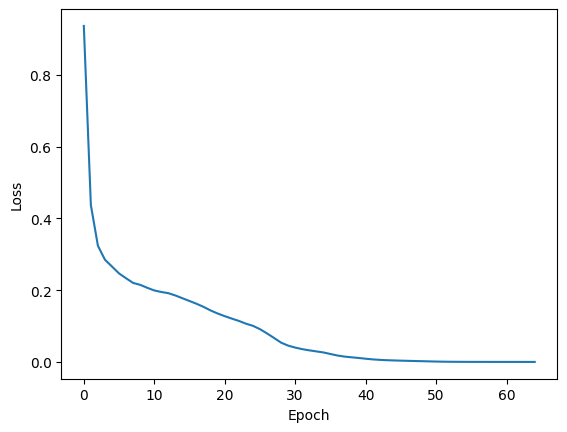

(9.22975959838368e-06, 64)

In [40]:
best_trial = study.best_trial
best_trial_values = trial_results[best_trial.number]
plot_losses(best_trial_values['all_losses'])
best_trial_values['final_loss'], best_trial_values['epochs']

## Gradient Descent Optimization

Epoch 0 Loss: 0.2574


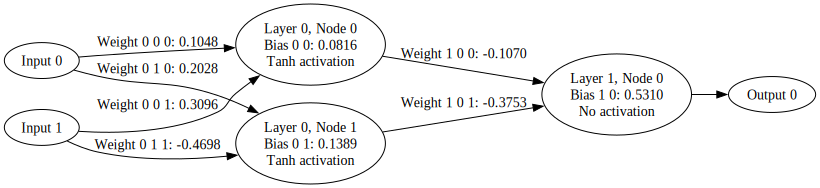

Early stopping on epoch 727 with loss 0.0000, because loss is below the treshold


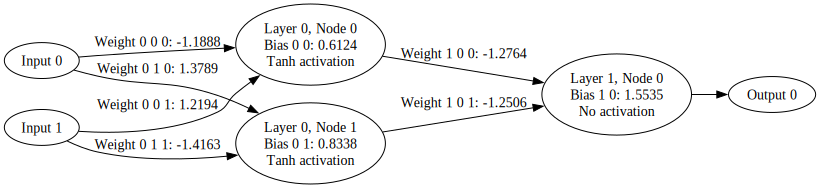

model(tensor([0., 0.])) => tensor([0.0033], grad_fn=<ViewBackward0>)
model(tensor([0., 1.])) => tensor([0.9968], grad_fn=<ViewBackward0>)
model(tensor([1., 0.])) => tensor([0.9963], grad_fn=<ViewBackward0>)
model(tensor([1., 1.])) => tensor([0.0020], grad_fn=<ViewBackward0>)


In [41]:
model = ANN(layers=LAYERS, requires_grad=True, activation_fn=nn.Tanh)
MAX_EPOCHS = 10000
LOSS_TRESHOLD = 1 * 10**-5
print_every_n_epochs = 1000
loss_fn = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0001) # 75 epochs
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # 60 epochs
# optimizer = torch.optim.AdamW(model.parameters(), lr = 0.017, eps=1e-07, weight_decay=0.001) # 55 epochs
all_losses = [] 
n_same_loss_early_stop = 100

for epoch in range(MAX_EPOCHS): 

    y_hat = model(X)

    loss = loss_fn(y_hat, Y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    all_losses.append(loss.detach().numpy())

    if epoch % print_every_n_epochs == 0:
        print(f'Epoch {epoch} Loss: {loss:.4f}')
        draw_pt_fc_layers(model)
    
    last_n_same = len(all_losses) > n_same_loss_early_stop and len(set(np.array(all_losses[-n_same_loss_early_stop:]).tolist())) == 1
    if loss < LOSS_TRESHOLD or last_n_same:
        print(f'Early stopping on epoch {epoch} with loss {loss:.4f}, because {"loss is below the treshold" if loss < LOSS_TRESHOLD else f"last {n_same_loss_early_stop} losses are the same"}')
        break

draw_pt_fc_layers(model)
for x in X:
    print(f"model({x}) => {model(x)}")

assert loss < LOSS_TRESHOLD, f"Loss {loss} is not below the treshold {LOSS_TRESHOLD}"

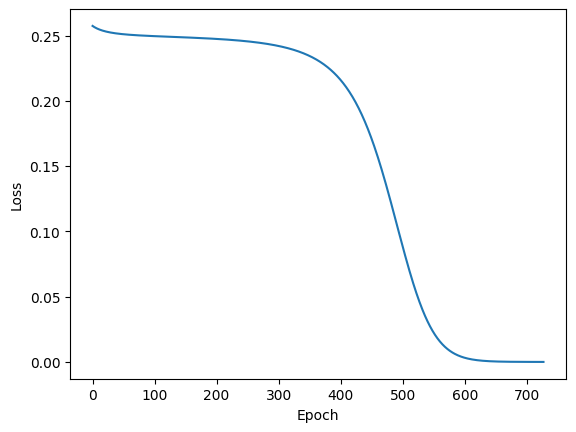

In [42]:
plot_losses(all_losses)